# CE7454 Project - Group 01
# Sleep stages classification using EEG signals
### Emadeldeen Ahmed, Lotfi Ismail, Rakaraddi Appan

The link to our GitHub repository is [here](https://github.com/ismail0T/CE7454_project).


# Part I: Motivation
Sleep-wake classification is important for measuring the sleep quality as it significantly affects the quality of daily life and it helps in finding out sleep disorders. A lot of studies have been made in this field but most of them used hand-crafted features extraction which may lead to less accurate classification results and longer processing time. However, some new deep learning models can also be deployed to achieve better accuracy and faster results.

# Part II: Dataset Exploration
We will start by exploring and exploiting a public sleep EEG dataset, Physionet, which can be downloaded from [Physionet website](https://physionet.org/physiobank/database/sleep-edfx/). The dataset contains 78 whole-night PSG data and the corresponding hypnograms (sleep patterns).

PSG recordings include Electroencephalogram (EEG), Electrooculogram (EOG), Electromyogram (EMG) and Electrocardiogram (ECG) recordings [[1]](https://www.sciencedirect.com/science/article/pii/S0925231212008387). These PSG data can be classified as wake(W), Rapid Eye Movement (REM) sleep and Non-REM. Non-REM sleep is further divided into stages 1, 2, 3 and 4 [[2]](https://www.ncbi.nlm.nih.gov/pubmed/25629798). As indicated in the literature, the EEG are the most important and frequently used signals for analyzing sleep staging and many researches uses single-channel EEG to help reducing the sleep disturbances caused by PSG recording equipment.
In this analysis, we will explore using the same channel mentioned in the literature as well as using another channel besides. 
Note that we have tried using EOG recordings instead of EEG but didn't achieve better results.

In [1]:
import os
import random
import warnings
warnings.filterwarnings('ignore')
import datetime
import ntpath
from itertools import chain, repeat
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

import mne
from mne.io import read_raw_edf
from mne import viz

from bokeh.io import output_notebook
output_notebook()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from Utils import *
from NN_Utils import *

Loading BokehJS ...

In [ ]:
f = open('download_physionet_13.sh', 'r')
save_path = "/home/ismail/Dev/data_2013"
if not os.path.exists(save_path):
    os.makedirs(save_path)
lines = f.read()

for url in lines.split('\n'):
    file_name = url.split("/")[-1]
    file_save_path = os.path.join(save_path, file_name)
    urllib.request.urlretrieve(url,file_save_path)
print("Dataset is download successfully !!!")

In [3]:
ann2label = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4,
    "Sleep stage ?": 5,
    "Movement time": 5
}
# Label values
W = 0
N1 = 1
N2 = 2
N3 = 3
REM = 4
UNKNOWN = 5

sampling_rate = 100.0
EPOCH_SEC_SIZE = 30

In [25]:
data_path = '/home/ismail/Dev/data_2013'
# single subject
data_files = os.listdir(data_path)

edf_data_files = [i for i in data_files if "-PSG" in i]
hyp_data_files = [i for i in data_files if "Hypnogram" in i]

edf_files_path = os.path.join(data_path, edf_data_files[10])
hyp_files_path = os.path.join(data_path, hyp_data_files[10])

print(f"Number of PSG files used in analysis:       {len(edf_data_files)} files")
print(f"Number of hypnogram files used in analysis: {len(hyp_data_files)} files")

Number of PSG files used in analysis:       39 files
Number of hypnogram files used in analysis: 39 files


In [12]:
class_duration = {0:0,1:0,2:0,3:0,4:0}

for i in range(len(edf_data_files)):
#     psg_files_path = os.path.join(data_path, edf_data_files[i])
    hyp_files_path = os.path.join(data_path, hyp_data_files[i])
    
    # Read annotation and its header
    f = open(hyp_files_path, 'r', errors='ignore')
    reader_ann = BaseEDFReader(f)
    reader_ann.read_header()
    h_ann = reader_ann.header
    _, _, ann = zip(*reader_ann.records())
    f.close()
    ann_start_dt = datetime.datetime.strptime(h_ann['date_time'], "%Y-%m-%d %H:%M:%S")

    file_duration_in_sec = ann[0][len(ann[0])-1][0] + ann[0][len(ann[0])-1][1]
    
    # Generate label and remove indices
    count = 0
    for a in ann[0]:
        onset_sec, duration_sec, ann_char = a
        ann_str = ann_char[0][2:-1]
        label = ann2label[ann_str]
        if label != UNKNOWN:
            if duration_sec % EPOCH_SEC_SIZE != 0:
                raise Exception("Something wrong")
            class_duration[label] += duration_sec
            count+=1


In [20]:
x = class_duration
import math
from bokeh.io import output_file, show
from bokeh.palettes import Category20c
from bokeh.palettes import Spectral6
from bokeh.plotting import figure
from bokeh.transform import cumsum
import pandas as pd
data = pd.Series(x).reset_index(name='value').rename(columns={'index':'class'})
data['angle'] = data['value']/data['value'].sum() * 2*math.pi
data['color'] = Category20c[len(x)]

p = figure(plot_height=350, title="Pie Chart", toolbar_location=None,
        tools="hover", tooltips="@class: @value")

p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend='Class', source=data)
show(p)

In [27]:
raw = read_raw_edf(edf_files_path, preload=True, stim_channel=None, verbose=False)

from bokeh.layouts import gridplot
from bokeh.plotting import figure

# Extract data from the first 5 channels, from 1 s to 3 s.
sfreq = raw.info['sfreq']

data = {}
times = {}
ch_names = {}
for ch in range(len(raw.info["chs"])): # 7 channels
    ch_names[ch] = raw.info["chs"][ch]['ch_name']
    data[ch], times[ch] = raw[ch, int(sfreq * 1):int(sfreq * 10)]

#data_1, times_1 = raw[1, int(sfreq * 1):int(sfreq * 10)]

# for i in range(len(raw.info["chs"])):
#     fig = plt.subplots(figsize=(10,8))
#     plt.plot(times[i], data[i].T)
#     plt.xlabel('Seconds')
#     plt.ylabel('$\mu V$')
#     plt.legend([ch_names[i]])
#     plt.show()


# create three plots
ss = []
for i in range(7):
    s = figure()
    s.line(times[i], data[i].squeeze(), color='navy', alpha=0.5, legend=[ch_names[i]])
    ss.append(s)
    
# s2 = figure()
# s2.line(times[1], data[1].squeeze(), color='navy', alpha=0.5, legend=[ch_names[1]])
# s3 = figure()
# s3.line(times[2], data[2].squeeze(), color='navy', alpha=0.5, legend=[ch_names[2]])
# make a grid
grid = gridplot(ss, ncols=1, plot_width=900, plot_height=250)

# show the results
show(grid)

# Part III: Dataset Preprocessing


In [ ]:
# %run -i 'prepare_physionet.py' 

# Part IV: Models
Since our dataset suffer from the imbalance problem, we will train our models on the data before and after oversampling.

In [2]:
# Global variables

classes = ['W', 'N1', 'N2', 'N3', 'REM']
n_classes = len(classes)
device = torch.device("cuda:1")
num_folds = 20

## Section A: Before oversampling

In [3]:
# Data Folder
data_dir_eeg = "../data_2013/eeg_fpz_cz"

### 1. MLP

In [4]:
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        self.n_classes = 5

        self.layer1 = nn.Linear(3000, 256, bias=False)
        self.layer2 = nn.Linear(256, self.n_classes, bias=False)

    def forward(self, x):
        x = x.reshape(x.size(0), x.size(1) * x.size(2))

        y = self.layer1(x)
        y = F.relu(y)

        scores = self.layer2(y)

        return  scores

In [5]:
model = MLP()
num_epochs = 30
batch_size = 128
learning_rate = 0.001

summary(model.cuda(), (1, 3000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         768,000
            Linear-2                    [-1, 5]           1,280
Total params: 769,280
Trainable params: 769,280
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 2.93
Estimated Total Size (MB): 2.95
----------------------------------------------------------------


In [6]:
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg, num_folds, num_epochs, learning_rate, batch_size, device, smote=False, do_print=False)
torch.save(confusion_matrix, 'conf_MLP.pt')
np.savez("train_MLP", train_history_over_CV)
np.savez("val_MLP", val_history_over_CV)

num_folds:  20  num_epochs:  30

Fold <1> 19:52:21
There are 769280 (0.77 million) parameters in this neural network

Fold <2> 19:53:35

Fold <3> 19:54:40

Fold <4> 19:55:48

Fold <5> 19:56:55

Fold <6> 19:58:02

Fold <7> 19:59:08

Fold <8> 20:00:15

Fold <9> 20:01:21

Fold <10> 20:02:28

Fold <11> 20:03:35

Fold <12> 20:04:42

Fold <13> 20:05:48

Fold <14> 20:06:55

Fold <15> 20:08:02

Fold <16> 20:09:09

Fold <17> 20:10:15

Fold <18> 20:11:23

Fold <19> 20:12:29

Fold <20> 20:13:37


Epoch: 1  max_acc= 44.98105518210612


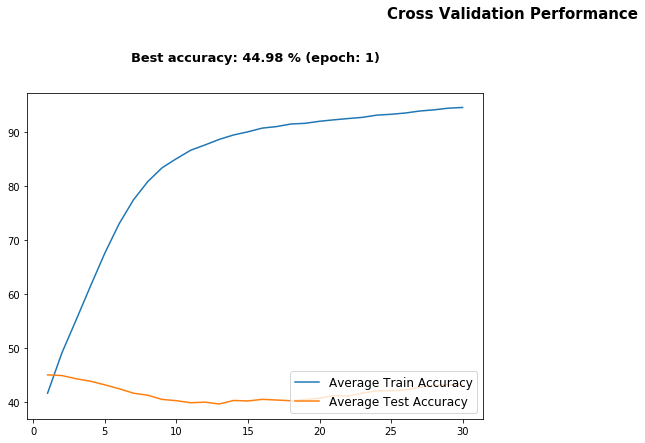

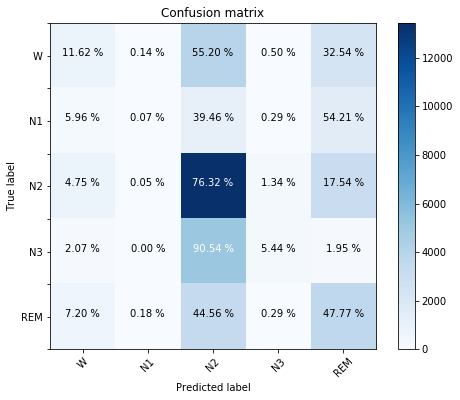

Acc  W 11.62 %
Acc  N1 0.07 %
Acc  N2 76.32 %
Acc  N3 5.44 %
Acc  REM 47.77 %


In [7]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

### 2. Conv1D

In [8]:
class ConvSimple(nn.Module):

    def __init__(self):
        super(ConvSimple, self).__init__()
        self.n_classes = 5
        self.conv1 = nn.Conv1d(1, 32, kernel_size=10, padding=1, stride=3)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=10, padding=1, stride=3)
        self.pool1 = nn.AvgPool1d(2, stride=6)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool1d(2, stride=2)

        self.conv5 = nn.Conv1d(64, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv1d(256, 256, kernel_size=3, padding=1)
        self.pool_avg = nn.AvgPool1d(2)

        self.linear1 = nn.Linear(3328, 128)

        self.dropout1 = nn.Dropout(0.2)

        # LL2:   128  -->  classes
        self.linear2 = nn.Linear(128, self.n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout1(x)

        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.pool_avg(x)
        x = self.dropout1(x)

        x = x.reshape(x.size(0), x.size(1) * x.size(2))
        # print(x.shape)  # 24'064

        x = self.linear1(x)
        x = F.relu(x)

        # Droput
        x = self.dropout1(x)

        # LL2:   128  -->  classes
        x = self.linear2(x)

        return x

In [9]:
model = ConvSimple()
num_epochs = 30
batch_size = 128
learning_rate = 0.001

summary(model.cuda(), (1, 3000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 998]             352
            Conv1d-2              [-1, 32, 331]          10,272
         AvgPool1d-3               [-1, 32, 55]               0
           Dropout-4               [-1, 32, 55]               0
            Conv1d-5               [-1, 64, 55]           6,208
            Conv1d-6               [-1, 64, 55]          12,352
         AvgPool1d-7               [-1, 64, 27]               0
           Dropout-8               [-1, 64, 27]               0
            Conv1d-9              [-1, 256, 27]          49,408
           Conv1d-10              [-1, 256, 27]         196,864
        AvgPool1d-11              [-1, 256, 13]               0
          Dropout-12              [-1, 256, 13]               0
           Linear-13                  [-1, 128]         426,112
          Dropout-14                  [

In [10]:
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg, num_folds, num_epochs, learning_rate, batch_size, device, smote=False, do_print=False)
torch.save(confusion_matrix, 'conf_Conv.pt')
np.savez("train_Conv", train_history_over_CV)
np.savez("val_Conv", val_history_over_CV)

num_folds:  20  num_epochs:  30

Fold <1> 20:14:46
There are 702213 (0.70 million) parameters in this neural network

Fold <2> 20:17:35

Fold <3> 20:20:17

Fold <4> 20:23:00

Fold <5> 20:25:43

Fold <6> 20:28:24

Fold <7> 20:31:06

Fold <8> 20:33:48

Fold <9> 20:36:30

Fold <10> 20:39:11

Fold <11> 20:41:53

Fold <12> 20:44:34

Fold <13> 20:47:15

Fold <14> 20:49:56

Fold <15> 20:52:37

Fold <16> 20:55:18

Fold <17> 20:58:00

Fold <18> 21:00:42

Fold <19> 21:03:22

Fold <20> 21:06:03


Epoch: 26  max_acc= 73.837093920522


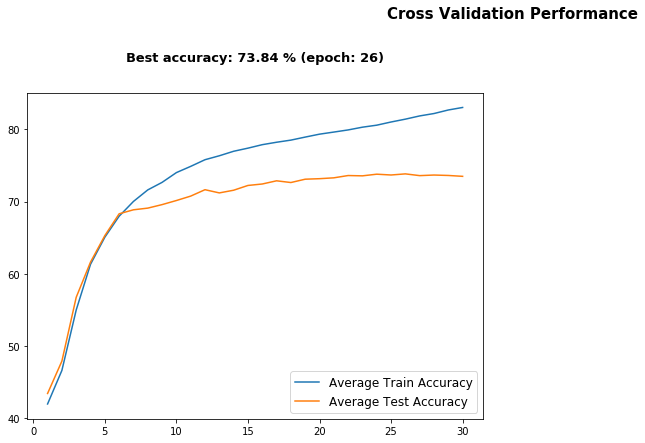

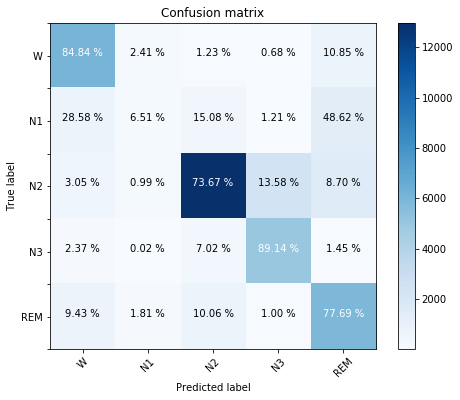

Acc  W 84.84 %
Acc  N1 6.51 %
Acc  N2 73.67 %
Acc  N3 89.14 %
Acc  REM 77.69 %


In [11]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

### 3. ConvBatchNorm

In [12]:
class ConvBatchNorm(nn.Module):

    def __init__(self):
        super(ConvBatchNorm, self).__init__()
        self.n_classes = 5
        self.conv1 = nn.Conv1d(1, 32, kernel_size=10, padding=1, stride=3)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=10, padding=1, stride=3)
        self.pool1 = nn.AvgPool1d(2, stride=6)
        self.bn1 = nn.BatchNorm1d(num_features=32)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool1d(2, stride=2)
        self.bn2 = nn.BatchNorm1d(num_features=64)

        self.conv5 = nn.Conv1d(64, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv1d(256, 256, kernel_size=3, padding=1)
        self.pool_avg = nn.AvgPool1d(2)
        self.bn3 = nn.BatchNorm1d(num_features=256)


        self.linear1 = nn.Linear(3328, 128)

        self.dropout1 = nn.Dropout(0.2)

        self.linear2 = nn.Linear(128, self.n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv5(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool_avg(x)

        x = x.reshape(x.size(0), x.size(1) * x.size(2))

        x = self.linear1(x)
        x = F.relu(x)

        # Droput
        x = self.dropout1(x)

        # LL2:   128  -->  classes
        x = self.linear2(x)

        return x


In [13]:
model = ConvBatchNorm()
num_epochs = 30
batch_size = 128
learning_rate = 0.001

summary(model.cuda(), (1, 3000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 998]             352
       BatchNorm1d-2              [-1, 32, 998]              64
            Conv1d-3              [-1, 32, 331]          10,272
       BatchNorm1d-4              [-1, 32, 331]              64
         AvgPool1d-5               [-1, 32, 55]               0
            Conv1d-6               [-1, 64, 55]           6,208
       BatchNorm1d-7               [-1, 64, 55]             128
            Conv1d-8               [-1, 64, 55]          12,352
       BatchNorm1d-9               [-1, 64, 55]             128
        AvgPool1d-10               [-1, 64, 27]               0
           Conv1d-11              [-1, 256, 27]          49,408
      BatchNorm1d-12              [-1, 256, 27]             512
           Conv1d-13              [-1, 256, 27]         196,864
      BatchNorm1d-14              [-1, 

In [14]:
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg, num_folds, num_epochs, learning_rate, batch_size, device, smote=False, do_print=False)
torch.save(confusion_matrix, 'conf_ConvBatchNorm.pt')
np.savez("train_ConvBatchNorm", train_history_over_CV)
np.savez("val_ConvBatchNorm", val_history_over_CV)

num_folds:  20  num_epochs:  30

Fold <1> 21:08:49
There are 702917 (0.70 million) parameters in this neural network

Fold <2> 21:11:44

Fold <3> 21:14:38

Fold <4> 21:17:32

Fold <5> 21:20:28

Fold <6> 21:23:22

Fold <7> 21:26:17

Fold <8> 21:29:12

Fold <9> 21:32:07

Fold <10> 21:35:02

Fold <11> 21:37:56

Fold <12> 21:40:51

Fold <13> 21:43:45

Fold <14> 21:46:39

Fold <15> 21:49:33

Fold <16> 21:52:27

Fold <17> 21:55:21

Fold <18> 21:58:17

Fold <19> 22:01:09

Fold <20> 22:04:04


Epoch: 19  max_acc= 75.66208869890028


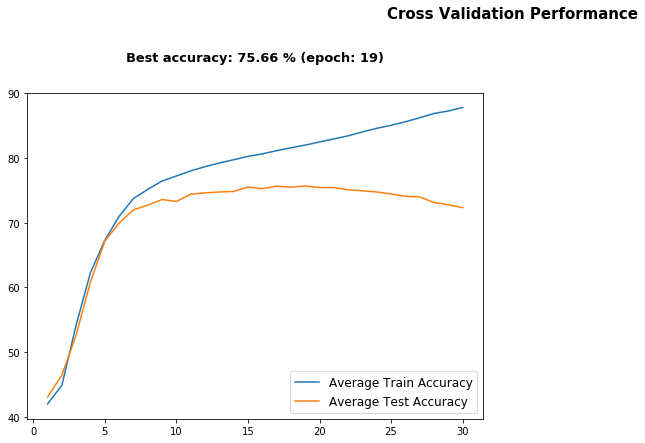

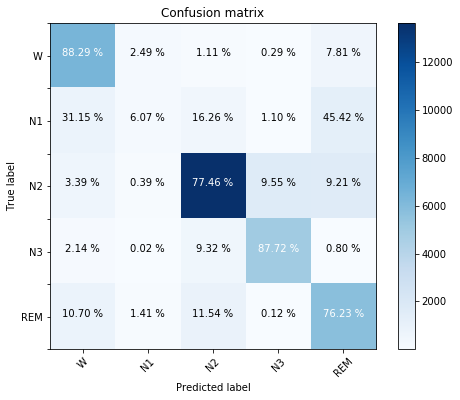

Acc  W 88.29 %
Acc  N1 6.07 %
Acc  N2 77.46 %
Acc  N3 87.72 %
Acc  REM 76.23 %


In [15]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

### 4. ConvLSTM

In [16]:
class ConvLSTM(nn.Module):

    def __init__(self, bi_dir=False):
        super(ConvLSTM, self).__init__()
        self.n_classes = 5
        self.hidden_dim = 256
        self.bi_dir = bi_dir

        # Conv
        self.conv1 = nn.Conv1d(1, 32, kernel_size=10, padding=1, stride=3)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=10, padding=1, stride=3)
        self.pool1 = nn.MaxPool1d(2, stride=6)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(2, stride=2)


        self.linear1 = nn.Linear(1728, 128)

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.6)


        # LSTM
        self.lstm_in_dim = 128
        self.lstm = nn.LSTM(self.lstm_in_dim, self.hidden_dim, bidirectional=self.bi_dir)

        # linear
        self.hidden2label1 = nn.Linear(self.hidden_dim * (1 + int(self.bi_dir)), self.n_classes)

    def forward(self, x, h_init, c_init):

        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout1(x)

        x = x.reshape(x.size(0), x.size(1) * x.size(2))
        # print(x.shape)  # 24'064

        x = self.linear1(x)
        x = F.relu(x)

        # Droput
        x = self.dropout1(x)



        cnn_x = F.relu(x)
        # print('cnn_x', cnn_x.shape)
        # LSTM
        g_seq = cnn_x.unsqueeze(dim=1)
        # print('g_seq', g_seq.shape)

        lstm_out, (h_final, c_final) = self.lstm(g_seq, (h_init, c_init))

        # Droput
        lstm_out = self.dropout2(lstm_out)

        # linear
        cnn_lstm_out = self.hidden2label1(lstm_out)  # activations are implicit

        # output
        scores = cnn_lstm_out

        return scores, h_final, c_final

In [17]:
model = ConvLSTM()
num_epochs = 50
batch_size = 64
learning_rate = 0.04

In [18]:
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg, num_folds, num_epochs, learning_rate, batch_size, device, smote=False, do_print=False)
torch.save(confusion_matrix, 'conf_ConvLSTM.pt')
np.savez("train_ConvLSTM", train_history_over_CV)
np.savez("val_ConvLSTM", val_history_over_CV)

num_folds:  20  num_epochs:  50

Fold <1> 22:07:02
There are 647045 (0.65 million) parameters in this neural network

Fold <2> 22:13:23

Fold <3> 22:19:45

Fold <4> 22:26:05

Fold <5> 22:32:30

Fold <6> 22:38:52

Fold <7> 22:45:15

Fold <8> 22:51:37

Fold <9> 22:57:59

Fold <10> 23:04:21

Fold <11> 23:10:41

Fold <12> 23:17:01

Fold <13> 23:23:23

Fold <14> 23:29:43

Fold <15> 23:36:03

Fold <16> 23:42:24

Fold <17> 23:48:46

Fold <18> 23:55:09

Fold <19> 00:01:28

Fold <20> 00:07:50


Epoch: 44  max_acc= 76.17277440121715


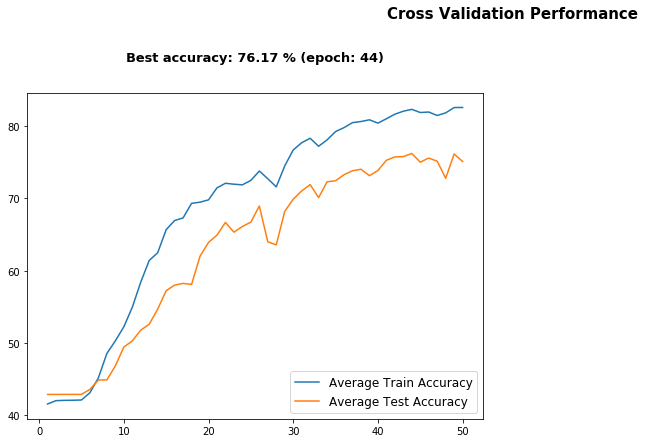

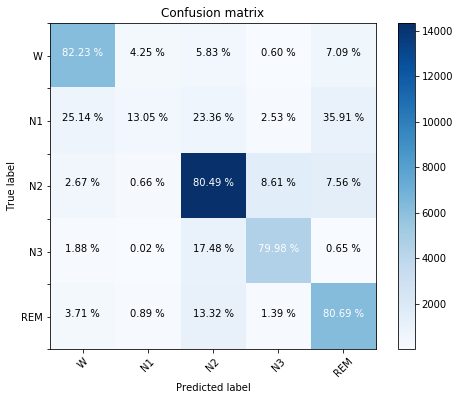

Acc  W 82.23 %
Acc  N1 13.05 %
Acc  N2 80.49 %
Acc  N3 79.98 %
Acc  REM 80.69 %


In [19]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

In [20]:
# best_epoch_id = 45
# confusion_matrix_test_CV = np.ones([20, 70, 5, 5])
# confusion_matrix_test_best = confusion_matrix_test_CV[0][best_epoch_id]
# for i in range(1, 20):
#     confusion_matrix_test_best += confusion_matrix_test_CV[i][best_epoch_id]

# print(confusion_matrix_test_best)

## Section B: After oversampling

In [21]:
# Data Folder
data_dir_eeg = "../data_2013/traindata_eeg"


### 1. MLP

In [22]:
model = MLP()
num_epochs = 20
batch_size = 128
learning_rate = 0.001

summary(model.cuda(), (1, 3000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         768,000
            Linear-2                    [-1, 5]           1,280
Total params: 769,280
Trainable params: 769,280
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 2.93
Estimated Total Size (MB): 2.95
----------------------------------------------------------------


In [23]:
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg, num_folds, num_epochs, learning_rate, batch_size, device, smote=True, do_print=False)
torch.save(confusion_matrix, 'conf_MLP_smote.pt')
np.savez("train_MLP_smote", train_history_over_CV)
np.savez("val_MLP_smote", val_history_over_CV)

num_folds:  20  num_epochs:  20

Fold <1> 00:14:24
There are 769280 (0.77 million) parameters in this neural network

Fold <2> 00:15:33

Fold <3> 00:16:38

Fold <4> 00:17:49

Fold <5> 00:18:56

Fold <6> 00:20:06

Fold <7> 00:21:14

Fold <8> 00:22:24

Fold <9> 00:23:33

Fold <10> 00:24:42

Fold <11> 00:25:53

Fold <12> 00:27:02

Fold <13> 00:28:11

Fold <14> 00:29:19

Fold <15> 00:30:28

Fold <16> 00:31:36

Fold <17> 00:32:46

Fold <18> 00:33:57

Fold <19> 00:35:04

Fold <20> 00:36:13


Epoch: 3  max_acc= 45.43790484943977


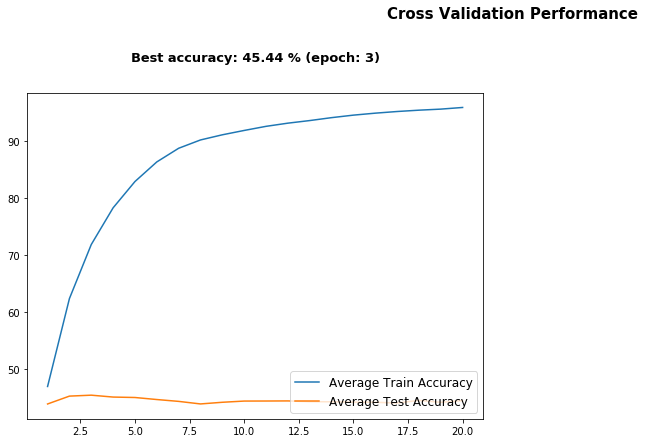

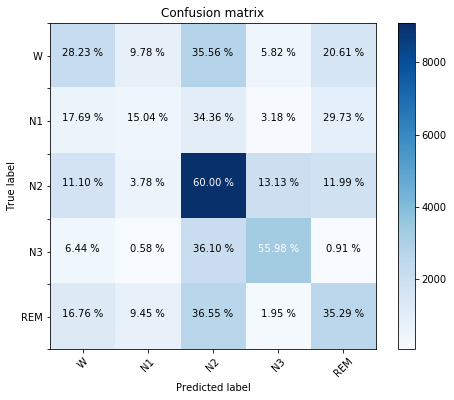

Acc  W 28.23 %
Acc  N1 15.04 %
Acc  N2 60.00 %
Acc  N3 55.98 %
Acc  REM 35.29 %


In [24]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

### 2. Conv1D

In [25]:
model = ConvSimple()
num_epochs = 30
batch_size = 128
learning_rate = 0.001

summary(model.cuda(), (1, 3000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 998]             352
            Conv1d-2              [-1, 32, 331]          10,272
         AvgPool1d-3               [-1, 32, 55]               0
           Dropout-4               [-1, 32, 55]               0
            Conv1d-5               [-1, 64, 55]           6,208
            Conv1d-6               [-1, 64, 55]          12,352
         AvgPool1d-7               [-1, 64, 27]               0
           Dropout-8               [-1, 64, 27]               0
            Conv1d-9              [-1, 256, 27]          49,408
           Conv1d-10              [-1, 256, 27]         196,864
        AvgPool1d-11              [-1, 256, 13]               0
          Dropout-12              [-1, 256, 13]               0
           Linear-13                  [-1, 128]         426,112
          Dropout-14                  [

In [26]:
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg, num_folds, num_epochs, learning_rate, batch_size, device, smote=True, do_print=False)
torch.save(confusion_matrix, 'conf_Conv_smote.pt')
np.savez("train_Conv_smote", train_history_over_CV)
np.savez("val_Conv_smote", val_history_over_CV)

num_folds:  20  num_epochs:  30

Fold <1> 00:37:19
There are 702213 (0.70 million) parameters in this neural network

Fold <2> 00:41:19

Fold <3> 00:45:12

Fold <4> 00:49:18

Fold <5> 00:53:19

Fold <6> 00:57:24

Fold <7> 01:01:25

Fold <8> 01:05:27

Fold <9> 01:09:30

Fold <10> 01:13:33

Fold <11> 01:17:39

Fold <12> 01:21:46

Fold <13> 01:25:45

Fold <14> 01:29:46

Fold <15> 01:33:48

Fold <16> 01:37:49

Fold <17> 01:41:51

Fold <18> 01:45:54

Fold <19> 01:49:54

Fold <20> 01:53:55


Epoch: 12  max_acc= 79.03035914886789


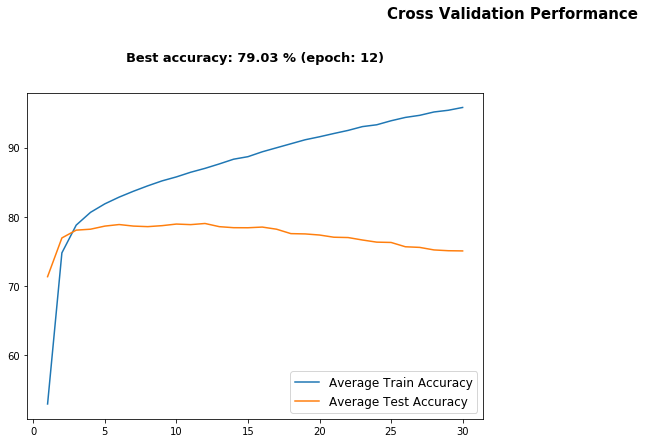

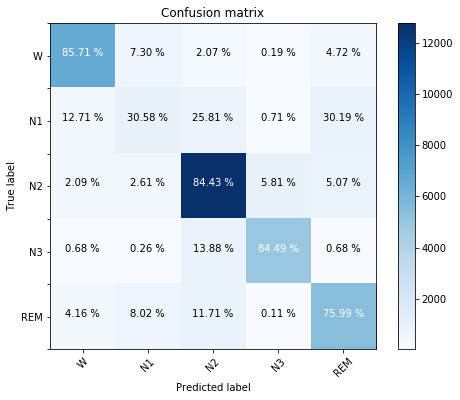

Acc  W 85.71 %
Acc  N1 30.58 %
Acc  N2 84.43 %
Acc  N3 84.49 %
Acc  REM 75.99 %


In [27]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

### 3. ConvBatchNorm

In [28]:
model = ConvBatchNorm()
num_epochs = 30
batch_size = 128
learning_rate = 0.001

summary(model.cuda(), (1, 3000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 998]             352
       BatchNorm1d-2              [-1, 32, 998]              64
            Conv1d-3              [-1, 32, 331]          10,272
       BatchNorm1d-4              [-1, 32, 331]              64
         AvgPool1d-5               [-1, 32, 55]               0
            Conv1d-6               [-1, 64, 55]           6,208
       BatchNorm1d-7               [-1, 64, 55]             128
            Conv1d-8               [-1, 64, 55]          12,352
       BatchNorm1d-9               [-1, 64, 55]             128
        AvgPool1d-10               [-1, 64, 27]               0
           Conv1d-11              [-1, 256, 27]          49,408
      BatchNorm1d-12              [-1, 256, 27]             512
           Conv1d-13              [-1, 256, 27]         196,864
      BatchNorm1d-14              [-1, 

In [29]:
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg, num_folds, num_epochs, learning_rate, batch_size, device, smote=True, do_print=False)
torch.save(confusion_matrix, 'conf_ConvBatchNorm_smote.pt')
np.savez("train_ConvBatchNorm_smote", train_history_over_CV)
np.savez("val_ConvBatchNorm_smote", val_history_over_CV)

num_folds:  20  num_epochs:  30

Fold <1> 01:57:57
There are 702917 (0.70 million) parameters in this neural network

Fold <2> 02:02:10

Fold <3> 02:06:17

Fold <4> 02:10:36

Fold <5> 02:14:49

Fold <6> 02:19:06

Fold <7> 02:23:19

Fold <8> 02:27:32

Fold <9> 02:31:46

Fold <10> 02:36:00

Fold <11> 02:40:17

Fold <12> 02:44:35

Fold <13> 02:48:45

Fold <14> 02:52:57

Fold <15> 02:57:11

Fold <16> 03:01:23

Fold <17> 03:05:37

Fold <18> 03:09:52

Fold <19> 03:14:02

Fold <20> 03:18:16


Epoch: 8  max_acc= 78.4041683079482


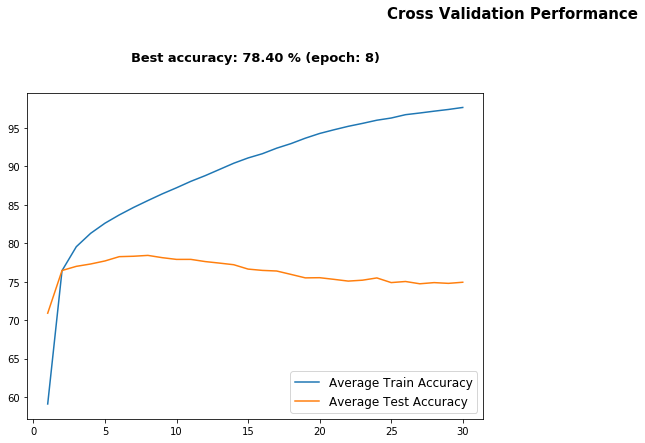

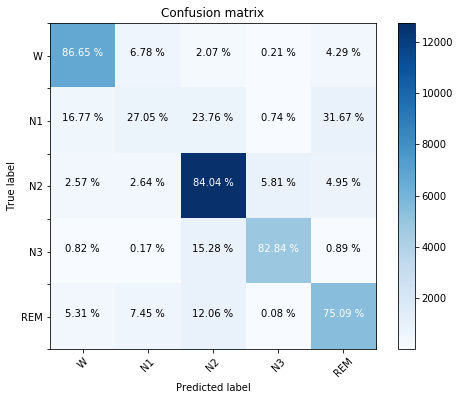

Acc  W 86.65 %
Acc  N1 27.05 %
Acc  N2 84.04 %
Acc  N3 82.84 %
Acc  REM 75.09 %


In [30]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

### 4. ConvLSTM

In [31]:
model = ConvLSTM()
num_epochs = 50
batch_size = 64
learning_rate = 0.04

In [32]:
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg, num_folds, num_epochs, learning_rate, batch_size, device, smote=True, do_print=False)
torch.save(confusion_matrix, 'conf_ConvLSTM_smote.pt')
np.savez("train_ConvLSTM_smote", train_history_over_CV)
np.savez("val_ConvLSTM_smote", val_history_over_CV)

num_folds:  20  num_epochs:  50

Fold <1> 03:22:31
There are 647045 (0.65 million) parameters in this neural network

Fold <2> 03:31:32

Fold <3> 03:40:20

Fold <4> 03:49:32

Fold <5> 03:58:38

Fold <6> 04:07:50

Fold <7> 04:16:54

Fold <8> 04:26:00

Fold <9> 04:35:08

Fold <10> 04:44:16

Fold <11> 04:53:29

Fold <12> 05:02:48

Fold <13> 05:11:47

Fold <14> 05:20:51

Fold <15> 05:29:59

Fold <16> 05:39:01

Fold <17> 05:48:10

Fold <18> 05:57:21

Fold <19> 06:06:21

Fold <20> 06:15:28


Epoch: 50  max_acc= 79.24931073117736


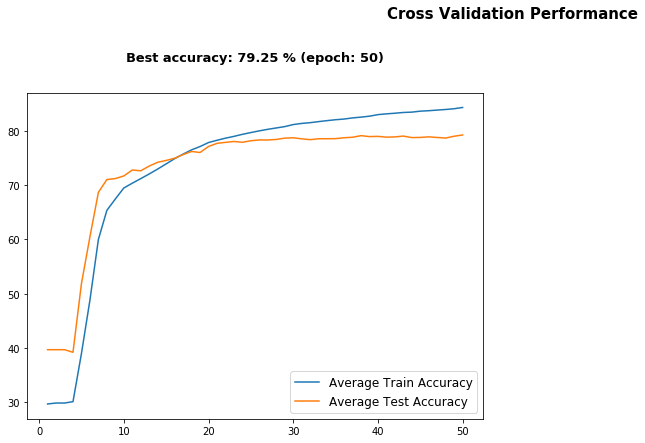

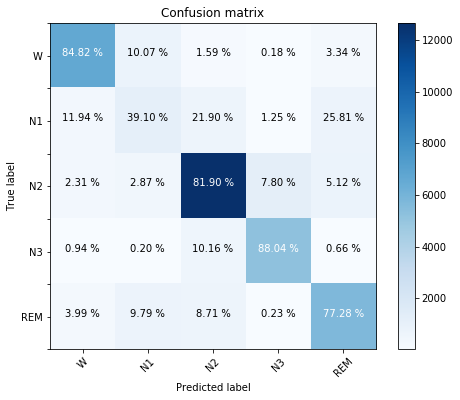

Acc  W 84.82 %
Acc  N1 39.10 %
Acc  N2 81.90 %
Acc  N3 88.04 %
Acc  REM 77.28 %


In [33]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)